# 固定验证集


In [14]:
import sys
sys.path.append('models')
import os
import torch
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from model_my_3D import MCAT_Surv
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 1. 数据集定义
class MCATDataset(Dataset):
    def __init__(self, ct_dir, dsa_dir, samples_df):
        self.ct_dir = ct_dir
        self.dsa_dir = dsa_dir
        self.samples_df = samples_df
        self.samples = samples_df['Number'].tolist()
        self.labels = samples_df['label'].tolist()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        ct_path = os.path.join(self.ct_dir, f"{sample_id}.pt")
        ct_feature = torch.load(ct_path).unsqueeze(1)

        dsa_path = os.path.join(self.dsa_dir, f"{sample_id}.pt")
        dsa_feature = torch.load(dsa_path)

        return ct_feature, dsa_feature, label, sample_id


# 2. 动态划分训练/验证集，确保训练集与验证集无重合
def split_data_from_label_file(label_path, ct_feature_dir, dsa_feature_dir):
    df = pd.read_excel(label_path, dtype={'Number': str})
    
    # 获取 'set' 列中为 'val' 的样本作为验证集
    val_samples = df[df['set'] == 'val']
    
    # 获取 'set' 为 'fail' 的样本排除
    df_remaining = df[df['set'] != 'fail']
    
    # 按类别（0 和 1）各自抽取 70 个样本作为训练集
    train_0 = df_remaining[(df_remaining['label'] == 0)].sample(n=70, random_state=42)
    train_1 = df_remaining[(df_remaining['label'] == 1)].sample(n=70, random_state=42)

    # 合并训练集和验证集
    df_train = pd.concat([train_0, train_1]).reset_index(drop=True)
    df_val = val_samples.reset_index(drop=True)

    # 创建数据集
    train_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, df_train)
    val_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, df_val)

    return train_dataset, val_dataset


# 3. 训练函数
def train_model(model, dataloader, optimizer, criterion, device, log_file, all_train_results, epoch):
    model.train()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    for ct_features, dsa_features, labels, sample_ids in dataloader:
        ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        optimizer.zero_grad()
        outputs, _ = model(ct_features, dsa_features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total_samples += labels.numel()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(preds.cpu().numpy().flatten())
        all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_train_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Train - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc


# 4. 验证函数
def evaluate_model(model, dataloader, criterion, device, log_file, all_val_results, epoch):
    model.eval()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    with torch.no_grad():
        for ct_features, dsa_features, labels, sample_ids in dataloader:
            ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            outputs, _ = model(ct_features, dsa_features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.numel()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(preds.cpu().numpy().flatten())
            all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_val_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Val - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc


# 5. 主程序入口
def main():
    ct_feature_dir = "/home/chenxi/MCAT/mydata/CT_all_features/"
    dsa_feature_dir = "/home/chenxi/MCAT/mydata/DSA_2D_features_whole/"
    label_path = "/home/chenxi/MCAT/mydata/new_old_check.xlsx"
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")   
    num_epochs = 30

    # 动态划分数据集
    train_dataset, val_dataset = split_data_from_label_file(label_path, ct_feature_dir, dsa_feature_dir)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    model = MCAT_Surv(fusion='concat', dropout=0.2).to(device)
    # 优化器改进
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.BCELoss()

    log_file_path = "training_log.txt"
    with open(log_file_path, "w") as log_file:
        log_file.write("Training Log\n")
        log_file.write("====================================\n")

        num_epochs = 30
        best_val_acc = 0.0
        save_path = "best_mcat_model.pth"

        all_train_results = []
        all_val_results = []

        for epoch in range(num_epochs):
            log_file.write(f"Epoch {epoch+1}/{num_epochs}:\n")

            train_loss, train_acc, train_auc = train_model(model, train_loader, optimizer, criterion, device, log_file, all_train_results, epoch)
            val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, log_file, all_val_results, epoch)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  📉 Train Loss: {train_loss:.4f} | 🎯 Train Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
            print(f"  📉 Val Loss:   {val_loss:.4f} | 🎯 Val Acc:   {val_acc:.4f} | AUC: {val_auc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 模型已保存: {save_path} (Val Acc: {best_val_acc:.4f})")

        train_result_df = all_train_results[0][["id", "true"]].copy()
        val_result_df = all_val_results[0][["id", "true"]].copy()
        for df in all_train_results:
            train_result_df = pd.merge(train_result_df, df.drop(columns="true"), on="id", how="left")
        for df in all_val_results:
            val_result_df = pd.merge(val_result_df, df.drop(columns="true"), on="id", how="left")

        with pd.ExcelWriter("predictions_summary.xlsx") as writer:
            train_result_df.to_excel(writer, sheet_name="Train", index=False)
            val_result_df.to_excel(writer, sheet_name="Val", index=False)

        print("🎉 训练完成！预测已保存为 predictions_summary.xlsx")

if __name__ == "__main__":
    main()


/home/chenxi/miniconda3/envs/insertD/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 5/30:
  📉 Train Loss: 0.6828 | 🎯 Train Acc: 0.6214 | AUC: 0.6214
  📉 Val Loss:   0.6881 | 🎯 Val Acc:   0.4545 | AUC: 0.5385
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_no

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.6364)
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 8/30:
  📉 Train Loss: 0.6729 | 🎯 Train Acc: 0.7500 | AUC: 0.7500
  📉 Val Loss:   0.6654 | 🎯 Val Acc:   0.6818 | AUC: 0.6282
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: tor

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 9/30:
  📉 Train Loss: 0.6628 | 🎯 Train Acc: 0.7071 | AUC: 0.7071
  📉 Val Loss:   0.6605 | 🎯 Val Acc:   0.6818 | AUC: 0.6282
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.S

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.8182)
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 12/30:
  📉 Train Loss: 0.6424 | 🎯 Train Acc: 0.8714 | AUC: 0.8714
  📉 Val Loss:   0.6428 | 🎯 Val Acc:   0.9091 | AUC: 0.9231
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 14/30:
  📉 Train Loss: 0.6219 | 🎯 Train Acc: 0.8500 | AUC: 0.8500
  📉 Val Loss:   0.6182 | 🎯 Val Acc:   0.9545 | AUC: 0.9615
✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.9545)
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape:

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 15/30:
  📉 Train Loss: 0.6081 | 🎯 Train Acc: 0.8857 | AUC: 0.8857
  📉 Val Loss:   0.6019 | 🎯 Val Acc:   0.8636 | AUC: 0.8504
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 16/30:
  📉 Train Loss: 0.5966 | 🎯 Train Acc: 0.8857 | AUC: 0.8857
  📉 Val Loss:   0.5863 | 🎯 Val Acc:   0.9545 | AUC: 0.9615
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 19/30:
  📉 Train Loss: 0.5368 | 🎯 Train Acc: 0.9286 | AUC: 0.9286
  📉 Val Loss:   0.5110 | 🎯 Val Acc:   1.0000 | AUC: 1.0000
✅ 模型已保存: best_mcat_model.pth (Val Acc: 1.0000)
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape:

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 20/30:
  📉 Train Loss: 0.5067 | 🎯 Train Acc: 0.9143 | AUC: 0.9143
  📉 Val Loss:   0.4843 | 🎯 Val Acc:   0.9545 | AUC: 0.9615
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 24/30:
  📉 Train Loss: 0.3773 | 🎯 Train Acc: 0.9571 | AUC: 0.9571
  📉 Val Loss:   0.3780 | 🎯 Val Acc:   0.9091 | AUC: 0.9231
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 27/30:
  📉 Train Loss: 0.2386 | 🎯 Train Acc: 0.9929 | AUC: 0.9929
  📉 Val Loss:   0.2999 | 🎯 Val Acc:   0.8636 | AUC: 0.8846
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([1

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 29/30:
  📉 Train Loss: 0.1774 | 🎯 Train Acc: 0.9929 | AUC: 0.9929
  📉 Val Loss:   0.2365 | 🎯 Val Acc:   0.9091 | AUC: 0.9231
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 1, 512])
h_ct shape: torch.

/tmp/ipykernel_394298/3947380541.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/3947380541.py:40: F

🎉 训练完成！预测已保存为 predictions_summary.xlsx


# 未避开错误样本

In [5]:
import os
import torch
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from model_my_3D import MCAT_Surv

# 1. 数据集定义
class MCATDataset(Dataset):
    def __init__(self, ct_dir, dsa_dir, samples_df):
        self.ct_dir = ct_dir
        self.dsa_dir = dsa_dir
        self.samples_df = samples_df
        self.samples = samples_df['Number'].tolist()
        self.labels = samples_df['label'].tolist()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        ct_path = os.path.join(self.ct_dir, f"{sample_id}.pt")
        ct_feature = torch.load(ct_path).unsqueeze(1)

        dsa_path = os.path.join(self.dsa_dir, f"{sample_id}.pt")
        dsa_feature = torch.load(dsa_path)

        return ct_feature, dsa_feature, label, sample_id


# 2. 动态划分训练/验证集，确保训练集与验证集无重合
def split_data_from_label_file(label_path, ct_feature_dir, dsa_feature_dir):
    df = pd.read_excel(label_path, dtype={'Number': str})
    
    # 获取 'set' 列中为 'val' 的样本作为验证集
    val_samples = df[df['set'] == 'val']
    
    # 获取剩下的样本作为训练集，并按类别（0 和 1）各自抽取 90 个样本
    train_0 = df[(df['label'] == 0) & (df['set'] != 'val')].sample(n=70, random_state=42)
    train_1 = df[(df['label'] == 1) & (df['set'] != 'val')].sample(n=70, random_state=42)

    # 合并训练集和验证集
    df_train = pd.concat([train_0, train_1]).reset_index(drop=True)
    df_val = val_samples.reset_index(drop=True)

    # 创建数据集
    train_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, df_train)
    val_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, df_val)

    return train_dataset, val_dataset


# 3. 训练函数
def train_model(model, dataloader, optimizer, criterion, device, log_file, all_train_results, epoch):
    model.train()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    for ct_features, dsa_features, labels, sample_ids in dataloader:
        ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        optimizer.zero_grad()
        outputs, _ = model(ct_features, dsa_features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total_samples += labels.numel()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(preds.cpu().numpy().flatten())
        all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_train_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Train - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc


# 4. 验证函数
def evaluate_model(model, dataloader, criterion, device, log_file, all_val_results, epoch):
    model.eval()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    with torch.no_grad():
        for ct_features, dsa_features, labels, sample_ids in dataloader:
            ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            outputs, _ = model(ct_features, dsa_features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.numel()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(preds.cpu().numpy().flatten())
            all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_val_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Val - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc


# 5. 主程序入口
def main():
    ct_feature_dir = "/home/chenxi/MCAT/mydata/CT_all_features/"
    dsa_feature_dir = "/home/chenxi/MAE_my_new/features_dsa_whole/"
    label_path = "/home/chenxi/MCAT/mydata/new_old_check.xlsx"
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")   
    num_epochs = 30

    # 动态划分数据集
    train_dataset, val_dataset = split_data_from_label_file(label_path, ct_feature_dir, dsa_feature_dir)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    model = MCAT_Surv(fusion='concat', dropout=0.2).to(device)
    # 优化器改进
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.BCELoss()

    log_file_path = "training_log.txt"
    with open(log_file_path, "w") as log_file:
        log_file.write("Training Log\n")
        log_file.write("====================================\n")

        num_epochs = 30
        best_val_acc = 0.0
        save_path = "best_mcat_model.pth"

        all_train_results = []
        all_val_results = []

        for epoch in range(num_epochs):
            log_file.write(f"Epoch {epoch+1}/{num_epochs}:\n")

            train_loss, train_acc, train_auc = train_model(model, train_loader, optimizer, criterion, device, log_file, all_train_results, epoch)
            val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, log_file, all_val_results, epoch)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  📉 Train Loss: {train_loss:.4f} | 🎯 Train Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
            print(f"  📉 Val Loss:   {val_loss:.4f} | 🎯 Val Acc:   {val_acc:.4f} | AUC: {val_auc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 模型已保存: {save_path} (Val Acc: {best_val_acc:.4f})")

        train_result_df = all_train_results[0][["id", "true"]].copy()
        val_result_df = all_val_results[0][["id", "true"]].copy()
        for df in all_train_results:
            train_result_df = pd.merge(train_result_df, df.drop(columns="true"), on="id", how="left")
        for df in all_val_results:
            val_result_df = pd.merge(val_result_df, df.drop(columns="true"), on="id", how="left")

        with pd.ExcelWriter("predictions_summary.xlsx") as writer:
            train_result_df.to_excel(writer, sheet_name="Train", index=False)
            val_result_df.to_excel(writer, sheet_name="Val", index=False)

        print("🎉 训练完成！预测已保存为 predictions_summary.xlsx")

if __name__ == "__main__":
    main()


/home/chenxi/miniconda3/envs/insertD/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 1/30:
  📉 Train Loss: 0.6937 | 🎯 Train Acc: 0.4929 | AUC: 0.4929
  📉 Val Loss:   0.6995 | 🎯 Val Acc:   0.4500 | AUC: 0.5000
✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.4500)
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 2/30:
  📉 Train Loss: 0.6909 | 🎯 Train Acc: 0.5500 | AUC: 0.5500
  📉 Val Loss:   0.6990 | 🎯 Val Acc:   0.5500 | AUC: 0.5505
✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.5500)
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

Epoch 3/30:
  📉 Train Loss: 0.6873 | 🎯 Train Acc: 0.5929 | AUC: 0.5929
  📉 Val Loss:   0.6984 | 🎯 Val Acc:   0.4000 | AUC: 0.3636
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([1

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 4/30:
  📉 Train Loss: 0.6849 | 🎯 Train Acc: 0.6143 | AUC: 0.6143
  📉 Val Loss:   0.6990 | 🎯 Val Acc:   0.4000 | AUC: 0.3636
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 6/30:
  📉 Train Loss: 0.6773 | 🎯 Train Acc: 0.7429 | AUC: 0.7429
  📉 Val Loss:   0.7012 | 🎯 Val Acc:   0.4500 | AUC: 0.4596
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.6000)
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 12/30:
  📉 Train Loss: 0.6548 | 🎯 Train Acc: 0.8500 | AUC: 0.8500
  📉 Val Loss:   0.7038 | 🎯 Val Acc:   0.5500 | AUC: 0.5202
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 51

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 17/30:
  📉 Train Loss: 0.6076 | 🎯 Train Acc: 0.8857 | AUC: 0.8857
  📉 Val Loss:   0.7046 | 🎯 Val Acc:   0.5000 | AUC: 0.4545
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 51

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 20/30:
  📉 Train Loss: 0.5628 | 🎯 Train Acc: 0.9000 | AUC: 0.9000
  📉 Val Loss:   0.7168 | 🎯 Val Acc:   0.5000 | AUC: 0.5354
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 51

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 24/30:
  📉 Train Loss: 0.4611 | 🎯 Train Acc: 0.9714 | AUC: 0.9714
  📉 Val Loss:   0.7206 | 🎯 Val Acc:   0.5500 | AUC: 0.5202
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 51

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 25/30:
  📉 Train Loss: 0.4125 | 🎯 Train Acc: 0.9786 | AUC: 0.9786
  📉 Val Loss:   0.7275 | 🎯 Val Acc:   0.6000 | AUC: 0.5859
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/1560388603.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/1560388603.py:30: F

# 抽取试错

In [19]:
import sys
sys.path.append('models')
import os
import torch
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from model_my_3D import MCAT_Surv
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 1. 数据集定义
class MCATDataset(Dataset):
    def __init__(self, ct_dir, dsa_dir, samples_df):
        self.ct_dir = ct_dir
        self.dsa_dir = dsa_dir
        self.samples_df = samples_df
        self.samples = samples_df['Number'].tolist()
        self.labels = samples_df['label'].tolist()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        ct_path = os.path.join(self.ct_dir, f"{sample_id}.pt")
        ct_feature = torch.load(ct_path).unsqueeze(1)

        dsa_path = os.path.join(self.dsa_dir, f"{sample_id}.pt")
        dsa_feature = torch.load(dsa_path)

        return ct_feature, dsa_feature, label, sample_id


# 2. 动态划分训练/验证集，确保训练集与验证集无重合
def split_data_from_label_file(label_path, ct_feature_dir, dsa_feature_dir, train_ratio=0.8):
    df = pd.read_excel(label_path, dtype={'Number': str})

    df_remaining = df[df['set']!='fail']
    
    # 按标签分类
    df_0 = df_remaining[df_remaining['label'] == 0]
    df_1 = df_remaining[df_remaining['label'] == 1]
    
    # 抽取 92 个类别为 0 的样本和 92 个类别为 1 的样本作为训练集
    train_0 = df_0.sample(n=65, random_state=42)
    train_1 = df_1.sample(n=65, random_state=42)
    
    # 剩余的样本用于验证集，抽取 23 个类别为 0 和 23 个类别为 1
    val_0 = df_0.drop(train_0.index).sample(n=10, random_state=42)
    val_1 = df_1.drop(train_1.index).sample(n=10, random_state=42)
    
    # 合并训练集和验证集
    df_train = pd.concat([train_0, train_1]).reset_index(drop=True)
    df_val = pd.concat([val_0, val_1]).reset_index(drop=True)

    # 创建数据集
    train_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, df_train)
    val_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, df_val)

    return train_dataset, val_dataset


# 3. 训练函数
def train_model(model, dataloader, optimizer, criterion, device, log_file, all_train_results, epoch):
    model.train()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    for ct_features, dsa_features, labels, sample_ids in dataloader:
        ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        optimizer.zero_grad()
        outputs, _ = model(ct_features, dsa_features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total_samples += labels.numel()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(preds.cpu().numpy().flatten())
        all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_train_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Train - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc


# 4. 验证函数
def evaluate_model(model, dataloader, criterion, device, log_file, all_val_results, epoch):
    model.eval()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    with torch.no_grad():
        for ct_features, dsa_features, labels, sample_ids in dataloader:
            ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            outputs, _ = model(ct_features, dsa_features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.numel()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(preds.cpu().numpy().flatten())
            all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_val_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Val - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc


# 5. 主程序入口
def main():
    ct_feature_dir = "/home/chenxi/MCAT/mydata/CT_all_features/"
    dsa_feature_dir = "/home/chenxi/MAE_my_new/features_dsa_whole/"
    label_path = "/home/chenxi/MCAT/mydata/new_old_check.xlsx"
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")   
    num_epochs = 30

    # 动态划分数据集
    train_dataset, val_dataset = split_data_from_label_file(label_path, ct_feature_dir, dsa_feature_dir)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    model = MCAT_Surv(fusion='concat', dropout=0.2).to(device)
    # 优化器改进
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.BCELoss()

    log_file_path = "training_log.txt"
    with open(log_file_path, "w") as log_file:
        log_file.write("Training Log\n")
        log_file.write("====================================\n")

        num_epochs = 30
        best_val_acc = 0.0
        save_path = "best_mcat_model.pth"

        all_train_results = []
        all_val_results = []

        for epoch in range(num_epochs):
            log_file.write(f"Epoch {epoch+1}/{num_epochs}:\n")

            train_loss, train_acc, train_auc = train_model(model, train_loader, optimizer, criterion, device, log_file, all_train_results, epoch)
            val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, log_file, all_val_results, epoch)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  📉 Train Loss: {train_loss:.4f} | 🎯 Train Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
            print(f"  📉 Val Loss:   {val_loss:.4f} | 🎯 Val Acc:   {val_acc:.4f} | AUC: {val_auc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 模型已保存: {save_path} (Val Acc: {best_val_acc:.4f})")

        train_result_df = all_train_results[0][["id", "true"]].copy()
        val_result_df = all_val_results[0][["id", "true"]].copy()
        for df in all_train_results:
            train_result_df = pd.merge(train_result_df, df.drop(columns="true"), on="id", how="left")
        for df in all_val_results:
            val_result_df = pd.merge(val_result_df, df.drop(columns="true"), on="id", how="left")

        with pd.ExcelWriter("predictions_summary.xlsx") as writer:
            train_result_df.to_excel(writer, sheet_name="Train", index=False)
            val_result_df.to_excel(writer, sheet_name="Val", index=False)

        print("🎉 训练完成！预测已保存为 predictions_summary.xlsx")

if __name__ == "__main__":
    main()


/home/chenxi/miniconda3/envs/insertD/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 1/30:
  📉 Train Loss: 0.6970 | 🎯 Train Acc: 0.4923 | AUC: 0.4923
  📉 Val Loss:   0.6713 | 🎯 Val Acc:   0.5000 | AUC: 0.5000
✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.5000)
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 2/30:
  📉 Train Loss: 0.6875 | 🎯 Train Acc: 0.5308 | AUC: 0.5308
  📉 Val Loss:   0.6797 | 🎯 Val Acc:   0.4500 | AUC: 0.4500
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.7000)
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 8/30:
  📉 Train Loss: 0.6738 | 🎯 Train Acc: 0.7923 | AUC: 0.7923
  📉 Val Loss:   0.6977 | 🎯 Val Acc:   0.6500 | AUC: 0.6500
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 10/30:
  📉 Train Loss: 0.6585 | 🎯 Train Acc: 0.8077 | AUC: 0.8077
  📉 Val Loss:   0.6994 | 🎯 Val Acc:   0.4500 | AUC: 0.4500
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 51

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 12/30:
  📉 Train Loss: 0.6429 | 🎯 Train Acc: 0.8846 | AUC: 0.8846
  📉 Val Loss:   0.7161 | 🎯 Val Acc:   0.5500 | AUC: 0.5500
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 51

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 14/30:
  📉 Train Loss: 0.6304 | 🎯 Train Acc: 0.9000 | AUC: 0.9000
  📉 Val Loss:   0.6964 | 🎯 Val Acc:   0.3500 | AUC: 0.3500
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Si

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

Epoch 16/30:
  📉 Train Loss: 0.6070 | 🎯 Train Acc: 0.8769 | AUC: 0.8769
  📉 Val Loss:   0.6838 | 🎯 Val Acc:   0.4000 | AUC: 0.4000
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 17/30:
  📉 Train Loss: 0.6027 | 🎯 Train Acc: 0.8462 | AUC: 0.8462
  📉 Val Loss:   0.6879 | 🎯 Val Acc:   0.4000 | AUC: 0.4000
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 51

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 19/30:
  📉 Train Loss: 0.5612 | 🎯 Train Acc: 0.9308 | AUC: 0.9308
  📉 Val Loss:   0.7343 | 🎯 Val Acc:   0.4000 | AUC: 0.4000
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 51

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 22/30:
  📉 Train Loss: 0.5118 | 🎯 Train Acc: 0.9385 | AUC: 0.9385
  📉 Val Loss:   0.7179 | 🎯 Val Acc:   0.3500 | AUC: 0.3500
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 51

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 25/30:
  📉 Train Loss: 0.4126 | 🎯 Train Acc: 0.9923 | AUC: 0.9923
  📉 Val Loss:   0.7793 | 🎯 Val Acc:   0.4500 | AUC: 0.4500
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 51

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 27/30:
  📉 Train Loss: 0.3556 | 🎯 Train Acc: 0.9769 | AUC: 0.9769
  📉 Val Loss:   0.7811 | 🎯 Val Acc:   0.4000 | AUC: 0.4000
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_f

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])
h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 29/30:
  📉 Train Loss: 0.2836 | 🎯 Train Acc: 0.9692 | AUC: 0.9692
  📉 Val Loss:   0.8505 | 🎯 Val Acc:   0.4500 | AUC: 0.4500
h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 51

/tmp/ipykernel_394298/292163141.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_394298/292163141.py:40: Fut

h_ct shape: torch.Size([4, 1, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 512])
h_ct shape: torch.Size([4, 1, 512]), h_dsa shape: torch.Size([4, 1, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
Epoch 30/30:
  📉 Train Loss: 0.2355 | 🎯 Train Acc: 0.9923 | AUC: 0.9923
  📉 Val Loss:   0.8563 | 🎯 Val Acc:   0.4000 | AUC: 0.4000
🎉 训练完成！预测已保存为 predictions_summary.xlsx


In [11]:
import sys
sys.path.append('models')
from model_my_3D import MCAT_Surv

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 1. 数据集定义
class MCATDataset(Dataset):
    def __init__(self, ct_dir, dsa_dir, samples_df):
        self.ct_dir = ct_dir
        self.dsa_dir = dsa_dir
        self.samples_df = samples_df
        self.samples = samples_df['Number'].tolist()
        self.labels = samples_df['label'].tolist()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        ct_path = os.path.join(self.ct_dir, f"{sample_id}.pt")
        ct_feature = torch.load(ct_path).unsqueeze(1)

        dsa_path = os.path.join(self.dsa_dir, f"{sample_id}.pt")
        dsa_feature = torch.load(dsa_path)

        return ct_feature, dsa_feature, label, sample_id

# 2. 动态划分训练/验证集
def split_data_from_label_file(label_path, ct_feature_dir, dsa_feature_dir, train_ratio=0.8):
    df = pd.read_excel(label_path, dtype={'Number': str})
    df_0 = df[df['label'] == 0]
    df_1 = df[df['label'] == 1]

    train_0, val_0 = train_test_split(df_0, train_size=train_ratio, random_state=42)
    train_1, val_1 = train_test_split(df_1, train_size=train_ratio, random_state=42)

    df_train = pd.concat([train_0, train_1]).reset_index(drop=True)
    df_val = pd.concat([val_0, val_1]).reset_index(drop=True)

    train_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, df_train)
    val_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, df_val)

    return train_dataset, val_dataset

# 3. 训练函数
def train_model(model, dataloader, optimizer, criterion, device, log_file, all_train_results, epoch):
    model.train()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    for ct_features, dsa_features, labels, sample_ids in dataloader:
        ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        optimizer.zero_grad()
        outputs, _ = model(ct_features, dsa_features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total_samples += labels.numel()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(preds.cpu().numpy().flatten())
        all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_train_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Train - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 4. 验证函数
def evaluate_model(model, dataloader, criterion, device, log_file, all_val_results, epoch):
    model.eval()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    with torch.no_grad():
        for ct_features, dsa_features, labels, sample_ids in dataloader:
            ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            outputs, _ = model(ct_features, dsa_features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.numel()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(preds.cpu().numpy().flatten())
            all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_val_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Val - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 5. 主程序入口
def main():
    ct_feature_dir = "/home/chenxi/MCAT/mydata/CT_3D_features_new/"
    dsa_feature_dir = "/home/chenxi/MAE_my_new/features_dsa/"
    label_path = "/home/chenxi/MCAT/mydata/label_new_origin.xlsx"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    num_epochs = 50

    # 动态划分数据集
    train_dataset, val_dataset = split_data_from_label_file(label_path, ct_feature_dir, dsa_feature_dir)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    model = MCAT_Surv(fusion='concat', dropout=0.2).to(device)
    # 优化器改进
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.BCELoss()

    log_file_path = "training_log.txt"
    with open(log_file_path, "w") as log_file:
        log_file.write("Training Log\n")
        log_file.write("====================================\n")

        num_epochs = 70
        best_val_acc = 0.0
        save_path = "best_mcat_model.pth"

        all_train_results = []
        all_val_results = []

        for epoch in range(num_epochs):
            log_file.write(f"Epoch {epoch+1}/{num_epochs}:\n")

            train_loss, train_acc, train_auc = train_model(model, train_loader, optimizer, criterion, device, log_file, all_train_results, epoch)
            val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, log_file, all_val_results, epoch)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  📉 Train Loss: {train_loss:.4f} | 🎯 Train Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
            print(f"  📉 Val Loss:   {val_loss:.4f} | 🎯 Val Acc:   {val_acc:.4f} | AUC: {val_auc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 模型已保存: {save_path} (Val Acc: {best_val_acc:.4f})")

        train_result_df = all_train_results[0][["id", "true"]].copy()
        val_result_df = all_val_results[0][["id", "true"]].copy()
        for df in all_train_results:
            train_result_df = pd.merge(train_result_df, df.drop(columns="true"), on="id", how="left")
        for df in all_val_results:
            val_result_df = pd.merge(val_result_df, df.drop(columns="true"), on="id", how="left")

        with pd.ExcelWriter("predictions_summary.xlsx") as writer:
            train_result_df.to_excel(writer, sheet_name="Train", index=False)
            val_result_df.to_excel(writer, sheet_name="Val", index=False)

        print("🎉 训练完成！预测已保存为 predictions_summary.xlsx")

if __name__ == "__main__":
    main()


/home/chenxi/miniconda3/envs/insertD/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_246593/2621400418.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe

h_ct shape: torch.Size([16, 1, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 512])
h_ct shape: torch.Size([16, 1, 512]), h_dsa shape: torch.Size([16, 1, 512])
h_ct_final shape: torch.Size([16, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([16, 512])
h_final_now: torch.Size([16, 512])


FileNotFoundError: [Errno 2] No such file or directory: '/home/chenxi/MAE_my_new/features_dsa/0101128962.pt'

# 按比例划分


In [3]:
import sys
sys.path.append('models')  # 添加 models 目录到 Python 路径
from model_my_3D import MCAT_Surv  # 直接导入 model_my.py 里的 MCAT_Surv

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from sklearn.model_selection import train_test_split  # 用于分层抽样
from sklearn.metrics import roc_auc_score  # 用于计算AUC

# **1. 数据集定义**
class MCATDataset(Dataset):
    def __init__(self, ct_dir, dsa_dir, label_path):
        """
        Args:
            ct_dir (str): 存储 CT 2D 特征的文件夹路径
            dsa_dir (str): 存储 DSA 2D 特征的文件夹路径
            label_path (str): 标签文件路径 (Excel)
        """
        self.ct_dir = ct_dir
        self.dsa_dir = dsa_dir
        
        # **让 `Number` 列以字符串形式读取**
        self.labels_df = pd.read_excel(label_path, sheet_name="train", dtype={'Number': str})

        self.samples = self.labels_df['Number'].tolist()  # 现在 `Number` 是字符串
        self.labels = self.labels_df['label'].tolist()    # `label` 保持原格式
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        # 加载 CT 特征
        ct_path = os.path.join(self.ct_dir, f"{sample_id}.pt")
        ct_feature = torch.load(ct_path)  # 形状: (1, 10, 256)

        # 加载 DSA 特征
        dsa_path = os.path.join(self.dsa_dir, f"{sample_id}.pt")
        dsa_feature = torch.load(dsa_path)  # 形状: (1, 1, 256)

        return ct_feature, dsa_feature, label
def train_model(model, dataloader, optimizer, criterion, device, log_file):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_labels = []
    all_probs = []

    for ct_features, dsa_features, labels in dataloader:
        ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)

        # 调整 label 形状使其与输出的形状一致
        labels = labels.unsqueeze(1)  # (batch_size,) -> (batch_size, 1)

        optimizer.zero_grad()
        outputs, _ = model(ct_features, dsa_features)  # 获取预测概率
        
        loss = criterion(outputs.squeeze(), labels.squeeze())  # BCE Loss
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = (outputs.squeeze() > 0.5).float()  # 二分类阈值 0.5
        correct += (preds == labels).sum().item()  # 增加正确预测的数量
        total_samples += labels.size(0)  # 增加总样本数

        # 收集预测概率和标签以计算AUC
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(outputs.cpu().detach().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples  # 正确预测的数量与总样本数量的比例

    # 计算AUC
    auc = roc_auc_score(all_labels, all_probs)

    # 记录日志
    log_file.write(f"Train - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")

    return avg_loss, accuracy, auc

def evaluate_model(model, dataloader, criterion, device, log_file):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for ct_features, dsa_features, labels in dataloader:
            ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)  # Adjust the shape of labels

            outputs, _ = model(ct_features, dsa_features)

            loss = criterion(outputs.squeeze(), labels.squeeze())
            total_loss += loss.item()

            preds = (outputs.squeeze() > 0.5).float()
            correct += (preds == labels).sum().item()  # 增加正确预测的数量
            total_samples += labels.size(0)  # 增加总样本数

            # 收集预测概率和标签以计算AUC
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().detach().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples  # 正确预测的数量与总样本数量的比例

    # 计算AUC
    auc = roc_auc_score(all_labels, all_probs)

    # 记录日志
    log_file.write(f"Val - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")

    return avg_loss, accuracy, auc


# **4. 数据集分层抽样**
def stratified_split(dataset, test_size=0.2):
    labels = dataset.labels  # 获取所有标签
    # 使用 sklearn 的 stratified split 保证按类别分层
    train_idx, val_idx = train_test_split(
        range(len(dataset)),
        test_size=test_size,
        stratify=labels,
        random_state=42
    )
    # 创建训练集和验证集
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    return train_subset, val_subset

# **5. 主训练流程**
def main():
    # **设置路径**
    ct_feature_dir = "/home/chenxi/MAE_my/features_ct"
    dsa_feature_dir = "/home/chenxi/MAE_my/features_dsa"
    label_path = "/home/chenxi/MCAT/mydata/label_new_origin.xlsx"
    
    # **设备选择**
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # **创建数据集**
    dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, label_path)

    # **分层抽样**
    train_dataset, val_dataset = stratified_split(dataset)

    # **数据加载器**
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    # **初始化模型**
    model = MCAT_Surv(fusion='concat').to(device)

    # **定义优化器和损失函数**
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    criterion = nn.BCELoss()  # 二分类损失函数

    # **创建并打开日志文件**
    log_file_path = "training_log.txt"
    with open(log_file_path, "w") as log_file:
        log_file.write("Training Log\n")
        log_file.write("====================================\n")
        
        # **训练**
        num_epochs = 40
        best_val_acc = 0.0
        save_path = "best_mcat_model.pth"

        for epoch in range(num_epochs):
            log_file.write(f"Epoch {epoch+1}/{num_epochs}:\n")
            
            train_loss, train_acc, train_auc = train_model(model, train_loader, optimizer, criterion, device, log_file)
            val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, log_file)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  📉 Train Loss: {train_loss:.4f} | 🎯 Train Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
            print(f"  📉 Val Loss: {val_loss:.4f} | 🎯 Val Acc: {val_acc:.4f} | AUC: {val_auc:.4f}")

            # **保存最佳模型**
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 模型已保存: {save_path} (Val Acc: {best_val_acc:.4f})")

        print("🎉 训练完成！")

# **运行训练脚本**
if __name__ == "__main__":
    main()


/home/chenxi/miniconda3/envs/insertD/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_434784/2849339809.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe

h_ct shape: torch.Size([1, 1, 512]), h_dsa shape: torch.Size([1, 1, 512])
h_ct shape: torch.Size([1, 512]), h_dsa shape: torch.Size([1, 512])
h_ct shape: torch.Size([1, 512]), h_dsa shape: torch.Size([1, 1, 512])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

# focal loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.29, gamma=10, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # 确保输入和目标形状一致
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # 计算交叉熵损失
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # 计算p_t
        pt = torch.exp(-BCE_loss)
        
        # 计算Focal loss
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        # 根据reduction方式处理损失
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [ ]:
import sys
sys.path.append('models')  # 添加 models 目录到 Python 路径
from model_my_3D import MCAT_Surv  # 直接导入 model_my.py 里的 MCAT_Surv

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from sklearn.model_selection import train_test_split  # 用于分层抽样
from sklearn.metrics import roc_auc_score  # 用于计算AUC

# **1. 数据集定义**
class MCATDataset(Dataset):
    def __init__(self, ct_dir, dsa_dir, label_path):
        """
        Args:
            ct_dir (str): 存储 CT 2D 特征的文件夹路径
            dsa_dir (str): 存储 DSA 2D 特征的文件夹路径
            label_path (str): 标签文件路径 (Excel)
        """
        self.ct_dir = ct_dir
        self.dsa_dir = dsa_dir
        
        # **让 `Number` 列以字符串形式读取**
        self.labels_df = pd.read_excel(label_path, sheet_name="Sheet2", dtype={'Number': str})

        self.samples = self.labels_df['Number'].tolist()  # 现在 `Number` 是字符串
        self.labels = self.labels_df['label'].tolist()    # `label` 保持原格式
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        # 加载 CT 特征
        ct_path = os.path.join(self.ct_dir, f"{sample_id}.pt")
        ct_feature = torch.load(ct_path)  # 形状: (1, 10, 256)

        # 加载 DSA 特征
        dsa_path = os.path.join(self.dsa_dir, f"{sample_id}.pt")
        dsa_feature = torch.load(dsa_path)  # 形状: (1, 1, 256)

        return ct_feature, dsa_feature, label
def train_model(model, dataloader, optimizer, criterion, device, log_file):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_labels = []
    all_probs = []

    for ct_features, dsa_features, labels in dataloader:
        ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)

        # 调整 label 形状使其与输出的形状一致
        labels = labels.unsqueeze(1)  # (batch_size,) -> (batch_size, 1)

        optimizer.zero_grad()
        outputs, _ = model(ct_features, dsa_features)  # 获取预测概率
        
        loss = criterion(outputs.squeeze(), labels.squeeze())  # 使用 Focal Loss
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = (outputs.squeeze() > 0.5).float()  # 二分类阈值 0.5
        correct += (preds == labels).sum().item()  # 增加正确预测的数量
        total_samples += labels.size(0)  # 增加总样本数

        # 收集预测概率和标签以计算AUC
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(outputs.cpu().detach().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples  # 正确预测的数量与总样本数量的比例

    # 计算AUC
    auc = roc_auc_score(all_labels, all_probs)

    # 记录日志
    log_file.write(f"Train - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")

    return avg_loss, accuracy, auc


def evaluate_model(model, dataloader, criterion, device, log_file):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for ct_features, dsa_features, labels in dataloader:
            ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)  # Adjust the shape of labels

            outputs, _ = model(ct_features, dsa_features)

            loss = criterion(outputs.squeeze(), labels.squeeze())
            total_loss += loss.item()

            preds = (outputs.squeeze() > 0.5).float()
            correct += (preds == labels).sum().item()  # 增加正确预测的数量
            total_samples += labels.size(0)  # 增加总样本数

            # 收集预测概率和标签以计算AUC
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().detach().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples  # 正确预测的数量与总样本数量的比例

    # 计算AUC
    auc = roc_auc_score(all_labels, all_probs)

    # 记录日志
    log_file.write(f"Val - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")

    return avg_loss, accuracy, auc



# **4. 数据集分层抽样**
def stratified_split(dataset, test_size=0.2):
    labels = dataset.labels  # 获取所有标签
    # 使用 sklearn 的 stratified split 保证按类别分层
    train_idx, val_idx = train_test_split(
        range(len(dataset)),
        test_size=test_size,
        stratify=labels,
        random_state=42
    )
    # 创建训练集和验证集
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    return train_subset, val_subset

# **5. 主训练流程**
def main():
    # **设置路径**
    ct_feature_dir = "/home/chenxi/MCAT/mydata/CT_2D_features_512_nol/"
    dsa_feature_dir = "/home/chenxi/MCAT/mydata/DSA_2D_features_512/"
    label_path = "/home/chenxi/MCAT/mydata/label.xlsx"
    
    # **设备选择**
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # **创建数据集**
    dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, label_path)

    # **分层抽样**
    train_dataset, val_dataset = stratified_split(dataset)

    # **数据加载器**
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    # **初始化模型**
    model = MCAT_Surv(fusion='bilinear').to(device)

    # **使用 Focal Loss**
    criterion = FocalLoss(alpha=0.29, gamma=10)  # 使用 FocalLoss

    # **定义优化器**
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

    # **创建并打开日志文件**
    log_file_path = "training_log.txt"
    with open(log_file_path, "w") as log_file:
        log_file.write("Training Log\n")
        log_file.write("====================================\n")
        
        # **训练**
        num_epochs = 60
        best_val_acc = 0.0
        save_path = "best_mcat_model.pth"

        for epoch in range(num_epochs):
            log_file.write(f"Epoch {epoch+1}/{num_epochs}:\n")
            
            train_loss, train_acc, train_auc = train_model(model, train_loader, optimizer, criterion, device, log_file)
            val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, log_file)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  📉 Train Loss: {train_loss:.4f} | 🎯 Train Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
            print(f"  📉 Val Loss: {val_loss:.4f} | 🎯 Val Acc: {val_acc:.4f} | AUC: {val_auc:.4f}")

            # **保存最佳模型**
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 模型已保存: {save_path} (Val Acc: {best_val_acc:.4f})")

        print("🎉 训练完成！")

# **运行训练脚本**
if __name__ == "__main__":
    main()



In [7]:
import torch

path = "/home/chenxi/MAE_my/features_dsa/0000283545.pt"
feature = torch.load(path, map_location='cpu')  # 加载 .pt 文件

print(f"✅ 文件已加载: {path}")
print(f"📐 特征形状: {feature.shape}")
print(f"📦 数据类型: {feature.dtype}")
print(f"📍 存储设备: {feature.device}")
print(f"🔍 前5个值: {feature.flatten()[:5]}")


✅ 文件已加载: /home/chenxi/MAE_my/features_dsa/0000283545.pt
📐 特征形状: torch.Size([1, 512])
📦 数据类型: torch.float32
📍 存储设备: cpu
🔍 前5个值: tensor([ 0.0175,  1.1526,  0.3660, -0.0269,  0.4318])


/tmp/ipykernel_433847/1683487806.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(path, map_location='cpu')  # 加载 .pt 文件


In [9]:
import torch

path = "/home/chenxi/MCAT/mydata/DSA_2D_features_new/0000283545.pt"
feature = torch.load(path, map_location='cpu')  # 加载 .pt 文件

print(f"✅ 文件已加载: {path}")
print(f"📐 特征形状: {feature.shape}")
print(f"📦 数据类型: {feature.dtype}")
print(f"📍 存储设备: {feature.device}")
print(f"🔍 前5个值: {feature.flatten()[:5]}")


✅ 文件已加载: /home/chenxi/MCAT/mydata/DSA_2D_features_new/0000283545.pt
📐 特征形状: torch.Size([1, 1, 512])
📦 数据类型: torch.float32
📍 存储设备: cpu
🔍 前5个值: tensor([-0.1545,  0.1108, -0.0797,  0.0911,  0.0818])


/tmp/ipykernel_433847/3679626690.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature = torch.load(path, map_location='cpu')  # 加载 .pt 文件


# 画AUC

# 3D融合

In [10]:
import sys
sys.path.append('models')
from model_my_3D import MCAT_Surv

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score



# 1. 数据集定义
class MCATDataset(Dataset):
    def __init__(self, ct_dir, dsa_dir, samples_df):
        self.ct_dir = ct_dir
        self.dsa_dir = dsa_dir
        self.samples_df = samples_df
        self.samples = samples_df['Number'].tolist()
        self.labels = samples_df['label'].tolist()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        ct_path = os.path.join(self.ct_dir, f"{sample_id}.pt")
        ct_feature = torch.load(ct_path).unsqueeze(1)

        dsa_path = os.path.join(self.dsa_dir, f"{sample_id}.pt")
        dsa_feature = torch.load(dsa_path)

        return ct_feature, dsa_feature, label, sample_id

# 2. 数据加载与划分

def load_and_split_data_train(label_path, ct_feature_dir, dsa_feature_dir):
    # 读取train.xlsx文件作为训练集
    df_train = pd.read_excel(label_path, dtype={'Number': str})
    # 创建训练集数据集
    train_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, df_train)

    return train_dataset

def load_and_split_data_val(label_path, ct_feature_dir, dsa_feature_dir):
    # 读取val.xlsx文件作为验证集
    df_val = pd.read_excel(label_path, dtype={'Number': str})
    # 创建验证集数据集
    val_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, df_val)

    return val_dataset

# 3. 训练函数

def train_model(model, dataloader, optimizer, criterion, device, log_file, all_train_results, epoch):
    model.train()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    for ct_features, dsa_features, labels, sample_ids in dataloader:
        ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        optimizer.zero_grad()
        outputs, _ = model(ct_features, dsa_features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total_samples += labels.numel()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(preds.cpu().numpy().flatten())
        all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_train_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Train - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 4. 评估函数

def evaluate_model(model, dataloader, criterion, device, log_file, all_val_results, epoch):
    model.eval()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    with torch.no_grad():
        for ct_features, dsa_features, labels, sample_ids in dataloader:
            ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            outputs, _ = model(ct_features, dsa_features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.numel()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(preds.cpu().numpy().flatten())
            all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_val_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Val - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 5. 主训练流程

def main():
    ct_feature_dir_train = "/home/chenxi/MCAT/mydata/CT_3D_features_new"
    dsa_feature_dir_train = "/home/chenxi/MCAT/mydata/DSA_2D_features_new"
    ct_feature_dir_val = "/home/chenxi/MCAT/mydata/CT_3D_features_new"
    dsa_feature_dir_val = "/home/chenxi/MCAT/mydata/DSA_2D_features_new"
    
    label_path_train = "/home/chenxi/MCAT/mydata/train2.xlsx"  # 用于训练集
    label_path_val = "/home/chenxi/MCAT/mydata/val2.xlsx"  # 用于验证集
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载训练集和验证集数据
    train_dataset = load_and_split_data_train(label_path_train, ct_feature_dir_train, dsa_feature_dir_train)
    val_dataset = load_and_split_data_val(label_path_val, ct_feature_dir_val, dsa_feature_dir_val)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    model = MCAT_Surv(fusion='concat', dropout=0.6).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
    criterion = nn.BCELoss()

    log_file_path = "training_log.txt"
    with open(log_file_path, "w") as log_file:
        log_file.write("Training Log\n")
        log_file.write("====================================\n")

        num_epochs = 100
        best_val_acc = 0.0
        save_path = "best_mcat_model.pth"

        all_train_results = []
        all_val_results = []

        for epoch in range(num_epochs):
            log_file.write(f"Epoch {epoch+1}/{num_epochs}:\n")

            train_loss, train_acc, train_auc = train_model(model, train_loader, optimizer, criterion, device, log_file, all_train_results, epoch)
            val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, log_file, all_val_results, epoch)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  \U0001f4c9 Train Loss: {train_loss:.4f} | \U0001f3af Train Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
            print(f"  \U0001f4c9 Val Loss: {val_loss:.4f} | \U0001f3af Val Acc: {val_acc:.4f} | AUC: {val_auc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 模型已保存: {save_path} (Val Acc: {best_val_acc:.4f})")

        train_result_df = all_train_results[0][["id", "true"]].copy()
        val_result_df = all_val_results[0][["id", "true"]].copy()
        for df in all_train_results:
            train_result_df = pd.merge(train_result_df, df.drop(columns="true"), on="id", how="left")
        for df in all_val_results:
            val_result_df = pd.merge(val_result_df, df.drop(columns="true"), on="id", how="left")

        with pd.ExcelWriter("predictions_summary.xlsx") as writer:
            train_result_df.to_excel(writer, sheet_name="Train", index=False)
            val_result_df.to_excel(writer, sheet_name="Val", index=False)

        print("🎉 训练完成！预测已保存为 predictions_summary.xlsx")

if __name__ == "__main__":
    main()


/home/chenxi/miniconda3/envs/insertD/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_saf

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 1/100:
  📉 Train Loss: 0.6931 | 🎯 Train Acc: 0.5060 | AUC: 0.5060
  📉 Val Loss: 0.6895 | 🎯 Val Acc: 0.5714 | AUC: 0.5000
✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.5714)
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.7857)
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct sha

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 8/100:
  📉 Train Loss: 0.6905 | 🎯 Train Acc: 0.5361 | AUC: 0.5361
  📉 Val Loss: 0.6827 | 🎯 Val Acc: 0.4286 | AUC: 0.5000
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct sha

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 12/100:
  📉 Train Loss: 0.6883 | 🎯 Train Acc: 0.5843 | AUC: 0.5843
  📉 Val Loss: 0.6821 | 🎯 Val Acc: 0.4286 | AUC: 0.5000
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 51

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct sha

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct sha

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 23/100:
  📉 Train Loss: 0.6727 | 🎯 Train Acc: 0.6928 | AUC: 0.6928
  📉 Val Loss: 0.6654 | 🎯 Val Acc: 0.4286 | AUC: 0.5000
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 29/100:
  📉 Train Loss: 0.6528 | 🎯 Train Acc: 0.6867 | AUC: 0.6867
  📉 Val Loss: 0.6300 | 🎯 Val Acc: 0.6429 | AUC: 0.6667
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 51

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: to

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 36/100:
  📉 Train Loss: 0.5776 | 🎯 Train Acc: 0.8133 | AUC: 0.8133
  📉 Val Loss: 0.5349 | 🎯 Val Acc: 0.7143 | AUC: 0.7292
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512]

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 39/100:
  📉 Train Loss: 0.4967 | 🎯 Train Acc: 0.8554 | AUC: 0.8554
  📉 Val Loss: 0.4501 | 🎯 Val Acc: 0.8571 | AUC: 0.8542
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 51

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: to

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct sha

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 50/100:
  📉 Train Loss: 0.2002 | 🎯 Train Acc: 0.9458 | AUC: 0.9458
  📉 Val Loss: 0.2513 | 🎯 Val Acc: 0.9286 | AUC: 0.9167
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 55/100:
  📉 Train Loss: 0.1214 | 🎯 Train Acc: 0.9819 | AUC: 0.9819
  📉 Val Loss: 0.2751 | 🎯 Val Acc: 0.9286 | AUC: 0.9167
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 63/100:
  📉 Train Loss: 0.1045 | 🎯 Train Acc: 0.9759 | AUC: 0.9759
  📉 Val Loss: 0.3470 | 🎯 Val Acc: 0.8571 | AUC: 0.8542
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 51

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct sha

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 68/100:
  📉 Train Loss: 0.0619 | 🎯 Train Acc: 0.9759 | AUC: 0.9759
  📉 Val Loss: 0.4332 | 🎯 Val Acc: 0.8571 | AUC: 0.8542
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 51

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct sha

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 80/100:
  📉 Train Loss: 0.0291 | 🎯 Train Acc: 0.9880 | AUC: 0.9880
  📉 Val Loss: 0.5667 | 🎯 Val Acc: 0.8571 | AUC: 0.8542
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 51

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct sha

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct sha

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([6, 1, 1, 512]), h_dsa shape: torch.Size([6, 1, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct shape: torch.Size([6, 1, 512]), h_dsa shape: torch.Size([6, 1, 512])
h_ct_final shape: torch.Size([6, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([6, 512])
h_final_now: torch.Size([6, 512])
Epoch 97/100:
  📉 Train Loss: 0.0245 | 🎯 Train Acc: 0.9880 | AUC: 0.9880
  📉 Val Loss: 0.7553 | 🎯 Val Acc: 0.8571 | AUC: 0.8542
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 51

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final s

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 1, 512])
h_ct sha

/tmp/ipykernel_3571900/1550102869.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_3571900/1550102869.py:36:

🎉 训练完成！预测已保存为 predictions_summary.xlsx


# 抽取

In [3]:
import sys
sys.path.append('models')
from model_my_3D import MCAT_Surv

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 1. 数据集定义
class MCATDataset(Dataset):
    def __init__(self, ct_dir, dsa_dir, samples_df):
        self.ct_dir = ct_dir
        self.dsa_dir = dsa_dir
        self.samples_df = samples_df
        self.samples = samples_df['Number'].tolist()
        self.labels = samples_df['label'].tolist()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        ct_path = os.path.join(self.ct_dir, f"{sample_id}.pt")
        ct_feature = torch.load(ct_path).unsqueeze(1)

        dsa_path = os.path.join(self.dsa_dir, f"{sample_id}.pt")
        dsa_feature = torch.load(dsa_path)

        return ct_feature, dsa_feature, label, sample_id

# 2. 数据加载与划分

def load_and_split_data(label_path, ct_feature_dir, dsa_feature_dir, train_size=0.8):
    # 读取label_new_origin.xlsx文件
    df = pd.read_excel(label_path, dtype={'Number': str})

    # 分开处理类别为1和0的样本
    df_class_1 = df[df['label'] == 1]
    df_class_0 = df[df['label'] == 0]

    # 从1类中随机抽取80%的样本作为训练集
    train_class_1, val_class_1 = train_test_split(df_class_1, test_size=0.2, random_state=42)

    # 从0类中随机抽取80%的样本作为训练集
    train_class_0, val_class_0 = train_test_split(df_class_0, test_size=0.2, random_state=42)

    # 合并训练集和验证集
    train_df = pd.concat([train_class_1, train_class_0])
    val_df = pd.concat([val_class_1, val_class_0])

    # 打乱训练集和验证集
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # 创建数据集
    train_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, train_df)
    val_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, val_df)

    return train_dataset, val_dataset

# 3. 训练函数

def train_model(model, dataloader, optimizer, criterion, device, log_file, all_train_results, epoch):
    model.train()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    for ct_features, dsa_features, labels, sample_ids in dataloader:
        ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        optimizer.zero_grad()
        outputs, _ = model(ct_features, dsa_features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total_samples += labels.numel()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(preds.cpu().numpy().flatten())
        all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_train_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Train - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 4. 评估函数

def evaluate_model(model, dataloader, criterion, device, log_file, all_val_results, epoch):
    model.eval()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    with torch.no_grad():
        for ct_features, dsa_features, labels, sample_ids in dataloader:
            ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            outputs, _ = model(ct_features, dsa_features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.numel()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(preds.cpu().numpy().flatten())
            all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_val_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Val - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 5. 主训练流程

def main():
    ct_feature_dir = "/home/chenxi/MAE_my/features_ct/"
    dsa_feature_dir = "/home/chenxi/MAE_my/features_dsa/"
    label_path = "/home/chenxi/MCAT/mydata/label_new_origin.xlsx"  # 更新为新的标签文件路径
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载和划分数据集
    train_dataset, val_dataset = load_and_split_data(label_path, ct_feature_dir, dsa_feature_dir)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    model = MCAT_Surv(fusion='concat', dropout=0.6).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
    criterion = nn.BCELoss()

    log_file_path = "training_log.txt"
    with open(log_file_path, "w") as log_file:
        log_file.write("Training Log\n")
        log_file.write("====================================\n")

        num_epochs = 100
        best_val_acc = 0.0
        save_path = "best_mcat_model.pth"

        all_train_results = []
        all_val_results = []

        for epoch in range(num_epochs):
            log_file.write(f"Epoch {epoch+1}/{num_epochs}:\n")

            train_loss, train_acc, train_auc = train_model(model, train_loader, optimizer, criterion, device, log_file, all_train_results, epoch)
            val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, log_file, all_val_results, epoch)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  \U0001f4c9 Train Loss: {train_loss:.4f} | \U0001f3af Train Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
            print(f"  \U0001f4c9 Val Loss: {val_loss:.4f} | \U0001f3af Val Acc: {val_acc:.4f} | AUC: {val_auc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 模型已保存: {save_path} (Val Acc: {best_val_acc:.4f})")

        train_result_df = all_train_results[0][["id", "true"]].copy()
        val_result_df = all_val_results[0][["id", "true"]].copy()
        for df in all_train_results:
            train_result_df = pd.merge(train_result_df, df.drop(columns="true"), on="id", how="left")
        for df in all_val_results:
            val_result_df = pd.merge(val_result_df, df.drop(columns="true"), on="id", how="left")

        with pd.ExcelWriter("predictions_summary.xlsx") as writer:
            train_result_df.to_excel(writer, sheet_name="Train", index=False)
            val_result_df.to_excel(writer, sheet_name="Val", index=False)

        print("🎉 训练完成！预测已保存为 predictions_summary.xlsx")

if __name__ == "__main__":
    main()


/home/chenxi/miniconda3/envs/insertD/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([2, 1, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 27/100:
  📉 Train Loss: 0.6928 | 🎯 Train Acc: 0.4940 | AUC: 0.4940
  📉 Val Loss: 0.6977 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shap

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 33/100:
  📉 Train Loss: 0.6938 | 🎯 Train Acc: 0.5301 | AUC: 0.5301
  📉 Val Loss: 0.6973 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_fina

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([2, 1, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 34/100:
  📉 Train Loss: 0.6969 | 🎯 Train Acc: 0.4277 | AUC: 0.4277
  📉 Val Loss: 0.6985 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shap

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 50/100:
  📉 Train Loss: 0.6968 | 🎯 Train Acc: 0.4518 | AUC: 0.4518
  📉 Val Loss: 0.6989 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_fina

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

Epoch 51/100:
  📉 Train Loss: 0.6915 | 🎯 Train Acc: 0.5542 | AUC: 0.5542
  📉 Val Loss: 0.6881 | 🎯 Val Acc: 0.6190 | AUC: 0.6190
✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.6190)
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])


/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([2, 1, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([2, 1, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.6429)
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.S

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([2, 1, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([2, 1, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 82/100:
  📉 Train Loss: 0.6959 | 🎯 Train Acc: 0.5181 | AUC: 0.5181
  📉 Val Loss: 0.6900 | 🎯 Val Acc: 0.6429 | AUC: 0.6429
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: t

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([2, 1, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 512])
h_ct shape: torch.Size([2, 1, 512]), h_dsa shape: torch.Size([2, 1, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 90/100:
  📉 Train Loss: 0.6904 | 🎯 Train Acc: 0.5663 | AUC: 0.5663
  📉 Val Loss: 0.6859 | 🎯 Val Acc: 0.6190 | AUC: 0.6190
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shap

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_final_now: torch.Size([2, 512])
Epoch 97/100:
  📉 Train Loss: 0.6902 | 🎯 Train Acc: 0.5181 | AUC: 0.5181
  📉 Val Loss: 0.6849 | 🎯 Val Acc: 0.6190 | AUC: 0.6190
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: t

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct shape: torch.Size([8, 1, 1, 512]), h_dsa shape: torch.Size([8, 1, 512])
h_ct shape: torch.Size(

/tmp/ipykernel_526367/4013180474.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_526367/4013180474.py:35: F

🎉 训练完成！预测已保存为 predictions_summary.xlsx


# 抽取小数据

In [1]:
import sys
sys.path.append('models')
from model_my_3D import MCAT_Surv

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

# 1. 数据集定义
class MCATDataset(Dataset):
    def __init__(self, ct_dir, dsa_dir, samples_df):
        self.ct_dir = ct_dir
        self.dsa_dir = dsa_dir
        self.samples_df = samples_df
        self.samples = samples_df['Number'].tolist()
        self.labels = samples_df['label'].tolist()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        ct_path = os.path.join(self.ct_dir, f"{sample_id}.pt")
        ct_feature = torch.load(ct_path).unsqueeze(1)

        dsa_path = os.path.join(self.dsa_dir, f"{sample_id}.pt")
        dsa_feature = torch.load(dsa_path)

        return ct_feature, dsa_feature, label, sample_id

# 2. 数据加载与划分

def load_and_split_data(label_path, ct_feature_dir, dsa_feature_dir, train_size=10, val_size=4):
    # 读取label_origin.xlsx文件
    df = pd.read_excel(label_path, dtype={'Number': str})

    # 分开处理类别为1和0的样本
    df_class_1 = df[df['label'] == 1]
    df_class_0 = df[df['label'] == 0]

    # 从1类和0类中各随机选取train_size个样本作为训练集
    train_class_1 = df_class_1.sample(n=train_size, random_state=42)
    train_class_0 = df_class_0.sample(n=train_size, random_state=42)

    # 剩下的作为验证集（从未抽到的类别中各抽取val_size个样本作为验证集）
    val_class_1 = df_class_1.drop(train_class_1.index).sample(n=val_size, random_state=42)
    val_class_0 = df_class_0.drop(train_class_0.index).sample(n=val_size, random_state=42)

    # 合并训练集和验证集
    train_df = pd.concat([train_class_1, train_class_0])
    val_df = pd.concat([val_class_1, val_class_0])

    # 打乱训练集和验证集
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # 创建数据集
    train_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, train_df)
    val_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, val_df)

    return train_dataset, val_dataset

# 3. 训练函数

def train_model(model, dataloader, optimizer, criterion, device, log_file, all_train_results, epoch):
    model.train()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    for ct_features, dsa_features, labels, sample_ids in dataloader:
        ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        optimizer.zero_grad()
        outputs, _ = model(ct_features, dsa_features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total_samples += labels.numel()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(preds.cpu().numpy().flatten())
        all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_train_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Train - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 4. 评估函数

def evaluate_model(model, dataloader, criterion, device, log_file, all_val_results, epoch):
    model.eval()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    with torch.no_grad():
        for ct_features, dsa_features, labels, sample_ids in dataloader:
            ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            outputs, _ = model(ct_features, dsa_features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.numel()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(preds.cpu().numpy().flatten())
            all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_val_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Val - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 5. 主训练流程

def main():
    ct_feature_dir = "/home/chenxi/MCAT/mydata/CT_features/"
    dsa_feature_dir = "/home/chenxi/MCAT/mydata/DSA_2D_features_512/"
    label_path = "/home/chenxi/MCAT/mydata/label_origin.xlsx"  # 更新为新的标签文件路径
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载和划分数据集
    train_dataset, val_dataset = load_and_split_data(label_path, ct_feature_dir, dsa_feature_dir)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    model = MCAT_Surv(fusion='concat', dropout=0.6).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
    criterion = nn.BCELoss()

    log_file_path = "training_log.txt"
    with open(log_file_path, "w") as log_file:
        log_file.write("Training Log\n")
        log_file.write("====================================\n")

        num_epochs = 50
        best_val_acc = 0.0
        save_path = "best_mcat_model.pth"

        all_train_results = []
        all_val_results = []

        for epoch in range(num_epochs):
            log_file.write(f"Epoch {epoch+1}/{num_epochs}:\n")

            train_loss, train_acc, train_auc = train_model(model, train_loader, optimizer, criterion, device, log_file, all_train_results, epoch)
            val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, log_file, all_val_results, epoch)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  \U0001f4c9 Train Loss: {train_loss:.4f} | \U0001f3af Train Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
            print(f"  \U0001f4c9 Val Loss: {val_loss:.4f} | \U0001f3af Val Acc: {val_acc:.4f} | AUC: {val_auc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 模型已保存: {save_path} (Val Acc: {best_val_acc:.4f})")

        train_result_df = all_train_results[0][["id", "true"]].copy()
        val_result_df = all_val_results[0][["id", "true"]].copy()
        for df in all_train_results:
            train_result_df = pd.merge(train_result_df, df.drop(columns="true"), on="id", how="left")
        for df in all_val_results:
            val_result_df = pd.merge(val_result_df, df.drop(columns="true"), on="id", how="left")

        with pd.ExcelWriter("predictions_summary.xlsx") as writer:
            train_result_df.to_excel(writer, sheet_name="Train", index=False)
            val_result_df.to_excel(writer, sheet_name="Val", index=False)

        print("🎉 训练完成！预测已保存为 predictions_summary.xlsx")

if __name__ == "__main__":
    main()


/home/chenxi/miniconda3/envs/insertD/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_saf

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 1/50:
  📉 Train Loss: 0.7050 | 🎯 Train Acc: 0.4500 | AUC: 0.4500
  📉 Val Loss: 0.6829 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.6250)
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Si

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 3/50:
  📉 Train Loss: 0.6850 | 🎯 Train Acc: 0.4500 | AUC: 0.4500
  📉 Val Loss: 0.6831 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 51

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 6/50:
  📉 Train Loss: 0.6921 | 🎯 Train Acc: 0.5000 | AUC: 0.5000
  📉 Val Loss: 0.6836 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 51

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 9/50:
  📉 Train Loss: 0.6935 | 🎯 Train Acc: 0.4500 | AUC: 0.4500
  📉 Val Loss: 0.6838 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 51

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 12/50:
  📉 Train Loss: 0.6906 | 🎯 Train Acc: 0.5000 | AUC: 0.5000
  📉 Val Loss: 0.6837 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 13/50:
  📉 Train Loss: 0.6917 | 🎯 Train Acc: 0.4500 | AUC: 0.4500
  📉 Val Loss: 0.6835 | 🎯 Val Acc: 0.6250 

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 15/50:
  📉 Train Loss: 0.6923 | 🎯 Train Acc: 0.5000 | AUC: 0.5000
  📉 Val Loss: 0.6834 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 16/50:
  📉 Train Loss: 0.6920 | 🎯 Train Acc: 0.5000 | AUC: 0.5000
  📉 Val Loss: 0.6835 | 🎯 Val Acc: 0.6250 

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 18/50:
  📉 Train Loss: 0.6826 | 🎯 Train Acc: 0.7000 | AUC: 0.7000
  📉 Val Loss: 0.6836 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 5

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

Epoch 20/50:
  📉 Train Loss: 0.6895 | 🎯 Train Acc: 0.5500 | AUC: 0.5500
  📉 Val Loss: 0.6835 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 21/50:
  📉 Train Loss: 0.6959 | 🎯 Train Acc: 0.5000 | AUC: 0.5000
  📉 Val Loss: 0.6836 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.S

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 25/50:
  📉 Train Loss: 0.6849 | 🎯 Train Acc: 0.5500 | AUC: 0.5500
  📉 Val Loss: 0.6842 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 26/50:
  📉 Train Loss: 0.6697 | 🎯 Train Acc: 0.7500 | AUC: 0.7500
  📉 Val Loss: 0.6843 | 🎯 Val Acc: 0.7500 

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 31/50:
  📉 Train Loss: 0.6877 | 🎯 Train Acc: 0.6500 | AUC: 0.6500
  📉 Val Loss: 0.6844 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 5

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 34/50:
  📉 Train Loss: 0.6785 | 🎯 Train Acc: 0.7000 | AUC: 0.7000
  📉 Val Loss: 0.6848 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 36/50:
  📉 Train Loss: 0.6732 | 🎯 Train Acc: 0.7500 | AUC: 0.7500
  📉 Val Loss: 0.6850 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 37/50:
  📉 Train Loss: 0.6692 | 🎯 Train Acc: 0.9000 | AUC: 0.9000
  📉 Val Loss: 0.6851 | 🎯 Val Acc: 0.5000 

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 39/50:
  📉 Train Loss: 0.6715 | 🎯 Train Acc: 0.8000 | AUC: 0.8000
  📉 Val Loss: 0.6852 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 42/50:
  📉 Train Loss: 0.6649 | 🎯 Train Acc: 0.8000 | AUC: 0.8000
  📉 Val Loss: 0.6857 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 5

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 45/50:
  📉 Train Loss: 0.6744 | 🎯 Train Acc: 0.7500 | AUC: 0.7500
  📉 Val Loss: 0.6861 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 48/50:
  📉 Train Loss: 0.6588 | 🎯 Train Acc: 0.8500 | AUC: 0.8500
  📉 Val Loss: 0.6868 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2902891/1275725119.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2902891/1275725119.py:34:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 50/50:
  📉 Train Loss: 0.6561 | 🎯 Train Acc: 0.8000 | AUC: 0.8000
  📉 Val Loss: 0.6873 | 🎯 Val Acc: 0.3750 | AUC: 0.3750
🎉 训练完成！预测已保存为 predictions_summary.xlsx


# 不同抽

In [1]:
import sys
sys.path.append('models')
from model_my_3D import MCAT_Surv

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 1. 数据集定义
class MCATDataset(Dataset):
    def __init__(self, ct_dir, dsa_dir, samples_df):
        self.ct_dir = ct_dir
        self.dsa_dir = dsa_dir
        self.samples_df = samples_df
        self.samples = samples_df['Number'].tolist()
        self.labels = samples_df['label'].tolist()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        ct_path = os.path.join(self.ct_dir, f"{sample_id}.pt")
        ct_feature = torch.load(ct_path).unsqueeze(1)

        dsa_path = os.path.join(self.dsa_dir, f"{sample_id}.pt")
        dsa_feature = torch.load(dsa_path)

        return ct_feature, dsa_feature, label, sample_id

# 2. 数据加载与划分

def load_and_split_data_train(label_path, ct_feature_dir, dsa_feature_dir):
    # 读取label_new_origin.xlsx文件作为训练集
    df_train = pd.read_excel(label_path, dtype={'Number': str})
    # 创建训练集数据集
    train_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, df_train)

    return train_dataset

def load_and_split_data_val(label_path, ct_feature_dir, dsa_feature_dir, val_size=13):
    # 读取label_origin.xlsx文件作为验证集
    df_val = pd.read_excel(label_path, dtype={'Number': str})

    # 分开处理类别为1和0的样本
    df_class_1 = df_val[df_val['label'] == 1]
    df_class_0 = df_val[df_val['label'] == 0]

    # 从1类中随机选取val_size个样本作为验证集
    val_class_1 = df_class_1.sample(n=val_size, random_state=42)
    # 从0类中随机选取val_size个样本作为验证集
    val_class_0 = df_class_0.sample(n=val_size, random_state=42)

    # 合并验证集
    val_df = pd.concat([val_class_1, val_class_0])

    # 打乱验证集
    val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # 创建验证集数据集
    val_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, val_df)

    return val_dataset

# 3. 训练函数

def train_model(model, dataloader, optimizer, criterion, device, log_file, all_train_results, epoch):
    model.train()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    for ct_features, dsa_features, labels, sample_ids in dataloader:
        ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        optimizer.zero_grad()
        outputs, _ = model(ct_features, dsa_features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total_samples += labels.numel()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(preds.cpu().numpy().flatten())
        all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_train_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Train - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 4. 评估函数

def evaluate_model(model, dataloader, criterion, device, log_file, all_val_results, epoch):
    model.eval()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    with torch.no_grad():
        for ct_features, dsa_features, labels, sample_ids in dataloader:
            ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            outputs, _ = model(ct_features, dsa_features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.numel()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(preds.cpu().numpy().flatten())
            all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_val_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Val - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 5. 主训练流程

def main():
    ct_feature_dir_train = "/home/chenxi/MCAT/mydata/CT_3D_features_new/"
    dsa_feature_dir_train = "/home/chenxi/MCAT/mydata/DSA_2D_features_new/"
    ct_feature_dir_val = "/home/chenxi/MCAT/mydata/CT_features/"
    dsa_feature_dir_val = "/home/chenxi/MCAT/mydata/DSA_2D_features_512/"
    label_path_train = "/home/chenxi/MCAT/mydata/label_new_origin.xlsx"  # 用于训练集
    label_path_val = "/home/chenxi/MCAT/mydata/label_origin.xlsx"  # 用于验证集
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载训练集数据
    train_dataset = load_and_split_data_train(label_path_train, ct_feature_dir_train, dsa_feature_dir_train)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

    # 加载验证集数据
    val_dataset = load_and_split_data_val(label_path_val, ct_feature_dir_val, dsa_feature_dir_val)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    model = MCAT_Surv(fusion='concat', dropout=0.6).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
    criterion = nn.BCELoss()

    log_file_path = "training_log.txt"
    with open(log_file_path, "w") as log_file:
        log_file.write("Training Log\n")
        log_file.write("====================================\n")

        num_epochs = 50
        best_val_acc = 0.0
        save_path = "best_mcat_model.pth"

        all_train_results = []
        all_val_results = []

        for epoch in range(num_epochs):
            log_file.write(f"Epoch {epoch+1}/{num_epochs}:\n")

            train_loss, train_acc, train_auc = train_model(model, train_loader, optimizer, criterion, device, log_file, all_train_results, epoch)
            val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, log_file, all_val_results, epoch)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  \U0001f4c9 Train Loss: {train_loss:.4f} | \U0001f3af Train Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
            print(f"  \U0001f4c9 Val Loss: {val_loss:.4f} | \U0001f3af Val Acc: {val_acc:.4f} | AUC: {val_auc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 模型已保存: {save_path} (Val Acc: {best_val_acc:.4f})")

        train_result_df = all_train_results[0][["id", "true"]].copy()
        val_result_df = all_val_results[0][["id", "true"]].copy()
        for df in all_train_results:
            train_result_df = pd.merge(train_result_df, df.drop(columns="true"), on="id", how="left")
        for df in all_val_results:
            val_result_df = pd.merge(val_result_df, df.drop(columns="true"), on="id", how="left")

        with pd.ExcelWriter("predictions_summary.xlsx") as writer:
            train_result_df.to_excel(writer, sheet_name="Train", index=False)
            val_result_df.to_excel(writer, sheet_name="Val", index=False)

        print("🎉 训练完成！预测已保存为 predictions_summary.xlsx")

if __name__ == "__main__":
    main()


/home/chenxi/miniconda3/envs/insertD/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_saf

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.5000)
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final sh

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 5/50:
  📉 Train Loss: 0.6917 | 🎯 Train Acc: 0.5385 | AUC: 0.5385
  📉 Val Loss: 0.6988 | 🎯 Val Acc: 0.4231 | AUC: 0.4231
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 51

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 10/50:
  📉 Train Loss: 0.6909 | 🎯 Train Acc: 0.5288 | AUC: 0.5288
  📉 Val Loss: 0.7004 | 🎯 Val Acc: 0.3846 | AUC: 0.3846
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.5385)
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 18/50:
  📉 Train Loss: 0.6820 | 🎯 Train Acc: 0.6635 | AUC: 0.6635
  📉 Val Loss: 0.7024 | 🎯 Val Acc: 0.4615 | AUC: 0.4615
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 33/50:
  📉 Train Loss: 0.6313 | 🎯 Train Acc: 0.7788 | AUC: 0.7788
  📉 Val Loss: 0.7289 | 🎯 Val Acc: 0.5385 | AUC: 0.5385
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 38/50:
  📉 Train Loss: 0.5465 | 🎯 Train Acc: 0.8221 | AUC: 0.8221
  📉 Val Loss: 0.7765 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 45/50:
  📉 Train Loss: 0.3712 | 🎯 Train Acc: 0.8462 | AUC: 0.8462
  📉 Val Loss: 1.0962 | 🎯 Val Acc: 0.5385 | AUC: 0.5385
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([2, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([2, 512])
h_final_now: torch.Size([2, 512])
Epoch 48/50:
  📉 Train Loss: 0.2871 | 🎯 Train Acc: 0.8990 | AUC: 0.8990
  📉 Val Loss: 1.2848 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_fi

/tmp/ipykernel_2898020/1360478729.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2898020/1360478729.py:35:

🎉 训练完成！预测已保存为 predictions_summary.xlsx


# 反过来训练

In [1]:
import sys
sys.path.append('models')
from model_my_3D import MCAT_Surv

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 1. 数据集定义
class MCATDataset(Dataset):
    def __init__(self, ct_dir, dsa_dir, samples_df):
        self.ct_dir = ct_dir
        self.dsa_dir = dsa_dir
        self.samples_df = samples_df
        self.samples = samples_df['Number'].tolist()
        self.labels = samples_df['label'].tolist()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        ct_path = os.path.join(self.ct_dir, f"{sample_id}.pt")
        ct_feature = torch.load(ct_path).unsqueeze(1)

        dsa_path = os.path.join(self.dsa_dir, f"{sample_id}.pt")
        dsa_feature = torch.load(dsa_path)

        return ct_feature, dsa_feature, label, sample_id

# 2. 数据加载与划分

def load_and_split_data_train(label_path, ct_feature_dir, dsa_feature_dir):
    # 读取label_origin.xlsx文件作为训练集
    df_train = pd.read_excel(label_path, dtype={'Number': str})

    # 分开处理类别为1和0的样本
    df_class_1 = df_train[df_train['label'] == 1]
    df_class_0 = df_train[df_train['label'] == 0]

    # 从1类中随机选取13个样本作为训练集
    train_class_1 = df_class_1.sample(n=14, random_state=42)
    # 从0类中随机选取13个样本作为训练集
    train_class_0 = df_class_0.sample(n=14, random_state=42)

    # 合并训练集
    train_df = pd.concat([train_class_1, train_class_0])

    # 打乱训练集
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # 创建训练集数据集
    train_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, train_df)

    return train_dataset

def load_and_split_data_val(label_path, ct_feature_dir, dsa_feature_dir, val_size=10):
    # 读取label_new_origin.xlsx文件作为验证集
    df_val = pd.read_excel(label_path, dtype={'Number': str})

    # 分开处理类别为1和0的样本
    df_class_1 = df_val[df_val['label'] == 1]
    df_class_0 = df_val[df_val['label'] == 0]

    # 从1类中随机选取val_size个样本作为验证集
    val_class_1 = df_class_1.sample(n=4, random_state=42)
    # 从0类中随机选取val_size个样本作为验证集
    val_class_0 = df_class_0.sample(n=4, random_state=42)

    # 合并验证集
    val_df = pd.concat([val_class_1, val_class_0])

    # 打乱验证集
    val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # 创建验证集数据集
    val_dataset = MCATDataset(ct_feature_dir, dsa_feature_dir, val_df)

    return val_dataset

# 3. 训练函数

def train_model(model, dataloader, optimizer, criterion, device, log_file, all_train_results, epoch):
    model.train()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    for ct_features, dsa_features, labels, sample_ids in dataloader:
        ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        optimizer.zero_grad()
        outputs, _ = model(ct_features, dsa_features)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total_samples += labels.numel()

        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(preds.cpu().numpy().flatten())
        all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_train_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Train - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 4. 评估函数

def evaluate_model(model, dataloader, criterion, device, log_file, all_val_results, epoch):
    model.eval()
    total_loss, correct, total_samples = 0, 0, 0
    all_labels, all_probs, all_ids = [], [], []

    with torch.no_grad():
        for ct_features, dsa_features, labels, sample_ids in dataloader:
            ct_features, dsa_features, labels = ct_features.to(device), dsa_features.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            outputs, _ = model(ct_features, dsa_features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total_samples += labels.numel()

            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(preds.cpu().numpy().flatten())
            all_ids.extend(sample_ids)

    df = pd.DataFrame({"id": all_ids, "true": all_labels, f"pred_epoch_{epoch}": all_probs})
    all_val_results.append(df)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    auc = roc_auc_score(all_labels, all_probs)

    log_file.write(f"Val - Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | AUC: {auc:.4f}\n")
    return avg_loss, accuracy, auc

# 5. 主训练流程

def main():
    ct_feature_dir_train = "/home/chenxi/MCAT/mydata/CT_features/"
    dsa_feature_dir_train = "/home/chenxi/MCAT/mydata/DSA_2D_features_512/"
    ct_feature_dir_val = "/home/chenxi/MCAT/mydata/CT_3D_features_new/"
    dsa_feature_dir_val = "/home/chenxi/MCAT/mydata/DSA_2D_features_new/"
    label_path_train = "/home/chenxi/MCAT/mydata/label_origin.xlsx"  # 用于训练集
    label_path_val = "/home/chenxi/MCAT/mydata/label_new_origin.xlsx"  # 用于验证集
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载训练集数据
    train_dataset = load_and_split_data_train(label_path_train, ct_feature_dir_train, dsa_feature_dir_train)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

    # 加载验证集数据
    val_dataset = load_and_split_data_val(label_path_val, ct_feature_dir_val, dsa_feature_dir_val)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    model = MCAT_Surv(fusion='concat', dropout=0.6).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
    criterion = nn.BCELoss()

    log_file_path = "training_log.txt"
    with open(log_file_path, "w") as log_file:
        log_file.write("Training Log\n")
        log_file.write("====================================\n")

        num_epochs = 200
        best_val_acc = 0.0
        save_path = "best_mcat_model.pth"

        all_train_results = []
        all_val_results = []

        for epoch in range(num_epochs):
            log_file.write(f"Epoch {epoch+1}/{num_epochs}:\n")

            train_loss, train_acc, train_auc = train_model(model, train_loader, optimizer, criterion, device, log_file, all_train_results, epoch)
            val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion, device, log_file, all_val_results, epoch)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"  \U0001f4c9 Train Loss: {train_loss:.4f} | \U0001f3af Train Acc: {train_acc:.4f} | AUC: {train_auc:.4f}")
            print(f"  \U0001f4c9 Val Loss: {val_loss:.4f} | \U0001f3af Val Acc: {val_acc:.4f} | AUC: {val_auc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"✅ 模型已保存: {save_path} (Val Acc: {best_val_acc:.4f})")

        train_result_df = all_train_results[0][["id", "true"]].copy()
        val_result_df = all_val_results[0][["id", "true"]].copy()
        for df in all_train_results:
            train_result_df = pd.merge(train_result_df, df.drop(columns="true"), on="id", how="left")
        for df in all_val_results:
            val_result_df = pd.merge(val_result_df, df.drop(columns="true"), on="id", how="left")

        with pd.ExcelWriter("predictions_summary.xlsx") as writer:
            train_result_df.to_excel(writer, sheet_name="Train", index=False)
            val_result_df.to_excel(writer, sheet_name="Val", index=False)

        print("🎉 训练完成！预测已保存为 predictions_summary.xlsx")

if __name__ == "__main__":
    main()


/home/chenxi/miniconda3/envs/insertD/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_saf

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 1/200:
  📉 Train Loss: 0.7032 | 🎯 Train Acc: 0.3929 | AUC: 0.3929
  📉 Val Loss: 0.6856 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.5000)
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.S

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 2/200:
  📉 Train Loss: 0.6909 | 🎯 Train Acc: 0.6071 | AUC: 0.6071
  📉 Val Loss: 0.6859 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 4/200:
  📉 Train Loss: 0.6878 | 🎯 Train Acc: 0.5000 | AUC: 0.5000
  📉 Val Loss: 0.6858 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 6/200:
  📉 Train Loss: 0.6835 | 🎯 Train Acc: 0.6071 | AUC: 0.6071
  📉 Val Loss: 0.6857 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 9/200:
  📉 Train Loss: 0.6894 | 🎯 Train Acc: 0.5357 | AUC: 0.5357
  📉 Val Loss: 0.6858 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 5

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 11/200:
  📉 Train Loss: 0.6853 | 🎯 Train Acc: 0.6429 | AUC: 0.6429
  📉 Val Loss: 0.6859 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 16/200:
  📉 Train Loss: 0.6827 | 🎯 Train Acc: 0.7500 | AUC: 0.7500
  📉 Val Loss: 0.6855 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512]

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 17/200:
  📉 Train Loss: 0.6818 | 🎯 Train Acc: 0.7143 | AUC: 0.7143
  📉 Val Loss: 0.6853 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 19/200:
  📉 Train Loss: 0.6872 | 🎯 Train Acc: 0.6786 | AUC: 0.6786
  📉 Val Loss: 0.6853 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 21/200:
  📉 Train Loss: 0.6826 | 🎯 Train Acc: 0.6071 | AUC: 0.6071
  📉 Val Loss: 0.6849 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 23/200:
  📉 Train Loss: 0.6881 | 🎯 Train Acc: 0.5714 | AUC: 0.5714
  📉 Val Loss: 0.6844 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 25/200:
  📉 Train Loss: 0.6764 | 🎯 Train Acc: 0.8214 | AUC: 0.8214
  📉 Val Loss: 0.6841 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 27/200:
  📉 Train Loss: 0.6709 | 🎯 Train Acc: 0.8929 | AUC: 0.8929
  📉 Val Loss: 0.6844 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 29/200:
  📉 Train Loss: 0.6820 | 🎯 Train Acc: 0.7143 | AUC: 0.7143
  📉 Val Loss: 0.6845 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 31/200:
  📉 Train Loss: 0.6783 | 🎯 Train Acc: 0.6429 | AUC: 0.6429
  📉 Val Loss: 0.6840 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 33/200:
  📉 Train Loss: 0.6825 | 🎯 Train Acc: 0.6786 | AUC: 0.6786
  📉 Val Loss: 0.6838 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 35/200:
  📉 Train Loss: 0.6733 | 🎯 Train Acc: 0.7857 | AUC: 0.7857
  📉 Val Loss: 0.6839 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 37/200:
  📉 Train Loss: 0.6768 | 🎯 Train Acc: 0.7143 | AUC: 0.7143
  📉 Val Loss: 0.6839 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 39/200:
  📉 Train Loss: 0.6662 | 🎯 Train Acc: 0.8929 | AUC: 0.8929
  📉 Val Loss: 0.6841 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 41/200:
  📉 Train Loss: 0.6821 | 🎯 Train Acc: 0.6071 | AUC: 0.6071
  📉 Val Loss: 0.6842 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 43/200:
  📉 Train Loss: 0.6727 | 🎯 Train Acc: 0.8214 | AUC: 0.8214
  📉 Val Loss: 0.6846 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_final_now: torch.Size([8, 512])
Epoch 44/200:
  📉 Train Loss: 0.6620 | 🎯 Train Acc: 0.8214 | AUC: 0.8214
  📉 Val Loss: 0.6847 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 45/200:
  📉 Train Loss: 0.6581 | 🎯 Train Acc: 0.8929 | AUC: 0.8929
  📉 V

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 46/200:
  📉 Train Loss: 0.6682 | 🎯 Train Acc: 0.7500 | AUC: 0.7500
  📉 Val Loss: 0.6846 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 50/200:
  📉 Train Loss: 0.6568 | 🎯 Train Acc: 0.8214 | AUC: 0.8214
  📉 Val Loss: 0.6842 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 52/200:
  📉 Train Loss: 0.6589 | 🎯 Train Acc: 0.8929 | AUC: 0.8929
  📉 Val Loss: 0.6842 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 54/200:
  📉 Train Loss: 0.6445 | 🎯 Train Acc: 0.8929 | AUC: 0.8929
  📉 Val Loss: 0.6836 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 56/200:
  📉 Train Loss: 0.6456 | 🎯 Train Acc: 0.9643 | AUC: 0.9643
  📉 Val Loss: 0.6827 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 57/200:
  📉 Train Loss: 0.6518 | 🎯 Train Acc: 0.9643 | AUC: 0.9643
  📉 Val Loss: 0.6824 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 59/200:
  📉 Train Loss: 0.6508 | 🎯 Train Acc: 0.8214 | AUC: 0.8214
  📉 Val Loss: 0.6816 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 61/200:
  📉 Train Loss: 0.6575 | 🎯 Train Acc: 0.9286 | AUC: 0.9286
  📉 Val Loss: 0.6810 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 63/200:
  📉 Train Loss: 0.6325 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.6810 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 65/200:
  📉 Train Loss: 0.6278 | 🎯 Train Acc: 0.9286 | AUC: 0.9286
  📉 Val Loss: 0.6805 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 67/200:
  📉 Train Loss: 0.6345 | 🎯 Train Acc: 0.8571 | AUC: 0.8571
  📉 Val Loss: 0.6802 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 71/200:
  📉 Train Loss: 0.6161 | 🎯 Train Acc: 0.8929 | AUC: 0.8929
  📉 Val Loss: 0.6803 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 73/200:
  📉 Train Loss: 0.6114 | 🎯 Train Acc: 0.9643 | AUC: 0.9643
  📉 Val Loss: 0.6796 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 75/200:
  📉 Train Loss: 0.6114 | 🎯 Train Acc: 0.9643 | AUC: 0.9643
  📉 Val Loss: 0.6789 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 77/200:
  📉 Train Loss: 0.6132 | 🎯 Train Acc: 0.9286 | AUC: 0.9286
  📉 Val Loss: 0.6784 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 79/200:
  📉 Train Loss: 0.5833 | 🎯 Train Acc: 0.9286 | AUC: 0.9286
  📉 Val Loss: 0.6781 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 81/200:
  📉 Train Loss: 0.5934 | 🎯 Train Acc: 0.8571 | AUC: 0.8571
  📉 Val Loss: 0.6773 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 83/200:
  📉 Train Loss: 0.5781 | 🎯 Train Acc: 0.8929 | AUC: 0.8929
  📉 Val Loss: 0.6766 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 85/200:
  📉 Train Loss: 0.5492 | 🎯 Train Acc: 0.9286 | AUC: 0.9286
  📉 Val Loss: 0.6758 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

✅ 模型已保存: best_mcat_model.pth (Val Acc: 0.7500)
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 87/200:
  📉 Train Loss: 0.5275 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.6752 | 🎯 Val Acc: 0.7500 | AUC: 0.7500
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 89/200:
  📉 Train Loss: 0.5174 | 🎯 Train Acc: 0.9643 | AUC: 0.9643
  📉 Val Loss: 0.6735 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dsa_feature = torch.load(dsa_path)
/tmp/ipykernel_2904393/3893167048.py:32: FutureWarn

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 91/200:
  📉 Train Loss: 0.4711 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.6730 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 93/200:
  📉 Train Loss: 0.5022 | 🎯 Train Acc: 0.9643 | AUC: 0.9643
  📉 Val Loss: 0.6713 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 95/200:
  📉 Train Loss: 0.4695 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.6709 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 97/200:
  📉 Train Loss: 0.4374 | 🎯 Train Acc: 0.9643 | AUC: 0.9643
  📉 Val Loss: 0.6720 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 99/200:
  📉 Train Loss: 0.4371 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.6734 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 101/200:
  📉 Train Loss: 0.4052 | 🎯 Train Acc: 0.9643 | AUC: 0.9643
  📉 Val Loss: 0.6753 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 103/200:
  📉 Train Loss: 0.3702 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.6795 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 105/200:
  📉 Train Loss: 0.3589 | 🎯 Train Acc: 0.9643 | AUC: 0.9643
  📉 Val Loss: 0.6845 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 108/200:
  📉 Train Loss: 0.3651 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.6914 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 110/200:
  📉 Train Loss: 0.2923 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.6992 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 112/200:
  📉 Train Loss: 0.2704 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.7095 | 🎯 Val Acc: 0.7500 | AUC: 0.7500
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 114/200:
  📉 Train Loss: 0.2557 | 🎯 Train Acc: 0.9643 | AUC: 0.9643
  📉 Val Loss: 0.7192 | 🎯 Val Acc: 0.7500 | AUC: 0.7500
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 116/200:
  📉 Train Loss: 0.2220 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.7291 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 119/200:
  📉 Train Loss: 0.1968 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.7444 | 🎯 Val Acc: 0.7500 | AUC: 0.7500
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 123/200:
  📉 Train Loss: 0.1575 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.7725 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 125/200:
  📉 Train Loss: 0.1423 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.7880 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 127/200:
  📉 Train Loss: 0.1474 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.8045 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 130/200:
  📉 Train Loss: 0.1128 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.8273 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 132/200:
  📉 Train Loss: 0.1294 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.8407 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 136/200:
  📉 Train Loss: 0.0826 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.8741 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 139/200:
  📉 Train Loss: 0.0826 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.8989 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 141/200:
  📉 Train Loss: 0.0670 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.9155 | 🎯 Val Acc: 0.5000 | AUC: 0.5000
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 143/200:
  📉 Train Loss: 0.0702 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.9325 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 147/200:
  📉 Train Loss: 0.0473 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.9691 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 149/200:
  📉 Train Loss: 0.0515 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.9785 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 152/200:
  📉 Train Loss: 0.0373 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 0.9940 | 🎯 Val Acc: 0.7500 | AUC: 0.7500
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 154/200:
  📉 Train Loss: 0.0429 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.0054 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 156/200:
  📉 Train Loss: 0.0423 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.0187 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 158/200:
  📉 Train Loss: 0.0355 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.0314 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 162/200:
  📉 Train Loss: 0.0296 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.0554 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 164/200:
  📉 Train Loss: 0.0286 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.0680 | 🎯 Val Acc: 0.7500 | AUC: 0.7500
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 167/200:
  📉 Train Loss: 0.0288 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.0861 | 🎯 Val Acc: 0.7500 | AUC: 0.7500
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 171/200:
  📉 Train Loss: 0.0246 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.1112 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 173/200:
  📉 Train Loss: 0.0220 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.1235 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 175/200:
  📉 Train Loss: 0.0163 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.1255 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 177/200:
  📉 Train Loss: 0.0215 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.1324 | 🎯 Val Acc: 0.7500 | AUC: 0.7500
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 179/200:
  📉 Train Loss: 0.0168 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.1431 | 🎯 Val Acc: 0.7500 | AUC: 0.7500
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 181/200:
  📉 Train Loss: 0.0190 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.1592 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 183/200:
  📉 Train Loss: 0.0154 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.1781 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 186/200:
  📉 Train Loss: 0.0217 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.1902 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 190/200:
  📉 Train Loss: 0.0155 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.2044 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 192/200:
  📉 Train Loss: 0.0135 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.2118 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 194/200:
  📉 Train Loss: 0.0148 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.2234 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 196/200:
  📉 Train Loss: 0.0149 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.2350 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 198/200:
  📉 Train Loss: 0.0154 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.2463 | 🎯 Val Acc: 0.6250 | AUC: 0.6250
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8,

/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
h_ct_final shape: torch.Size([4, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([4, 512])
h_final_now: torch.Size([4, 512])
h_ct_final shape: torch.Size([8, 512]), h_dsa_final shape: torch.Size([1, 512])
h_dsa_final_now: torch.Size([8, 512])
h_final_now: torch.Size([8, 512])
Epoch 200/200:
  📉 Train Loss: 0.0106 | 🎯 Train Acc: 1.0000 | AUC: 1.0000
  📉 Val Loss: 1.2556 | 🎯 Val Acc: 0.6250 | AUC: 0.6250


/tmp/ipykernel_2904393/3893167048.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_feature = torch.load(ct_path).unsqueeze(1)
/tmp/ipykernel_2904393/3893167048.py:35:

🎉 训练完成！预测已保存为 predictions_summary.xlsx


# 3D fotal loss

# logistic 回归

# SVM

# 画图


Skipping line due to format issue: Training Log



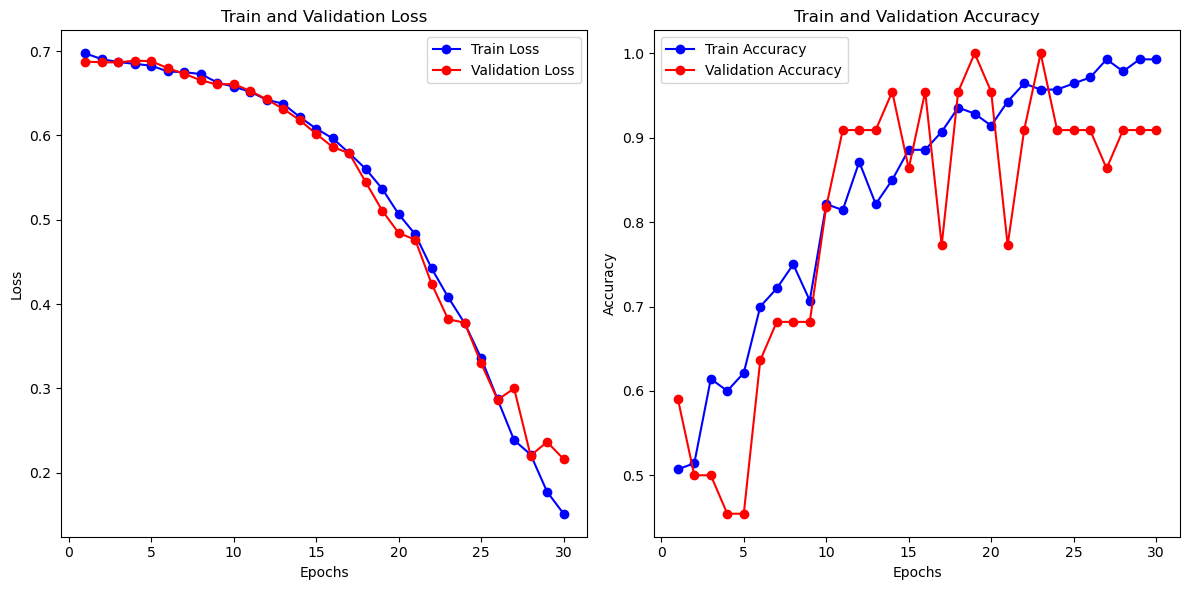

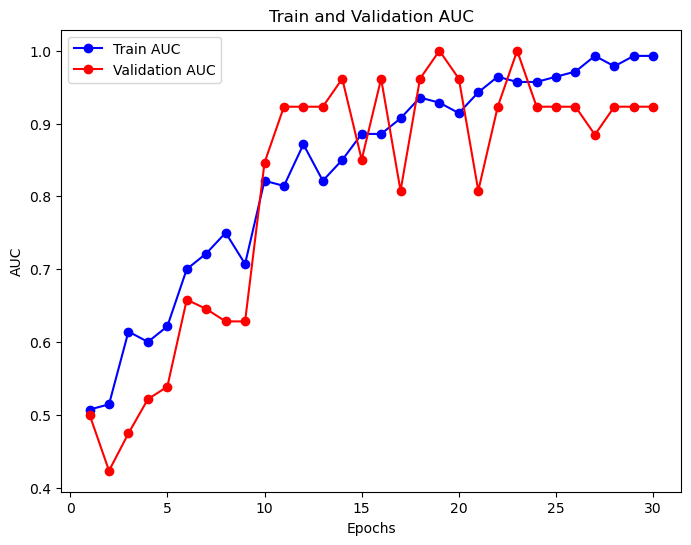

In [15]:
import matplotlib.pyplot as plt

# **读取 train_log.txt 文件并解析数据**
def parse_log_file(log_file_path):
    epochs = []
    train_losses = []
    train_accuracies = []
    train_auc = []
    val_losses = []
    val_accuracies = []
    val_auc = []

    with open(log_file_path, "r") as log_file:
        lines = log_file.readlines()

    for line in lines:
        try:
            if line.startswith("Epoch"):
                # 解析 Epoch 信息
                epoch = int(line.split('/')[0].split()[1])
                epochs.append(epoch)
            elif line.startswith("Train"):
                # 解析训练损失、准确率和AUC
                train_loss = float(line.split("Loss:")[1].split("|")[0].strip())
                train_accuracy = float(line.split("Acc:")[1].split("|")[0].strip())
                train_auc_score = float(line.split("AUC:")[1].strip())
                train_losses.append(train_loss)
                train_accuracies.append(train_accuracy)
                train_auc.append(train_auc_score)
            elif line.startswith("Val"):
                # 解析验证损失、准确率和AUC
                val_loss = float(line.split("Loss:")[1].split("|")[0].strip())
                val_accuracy = float(line.split("Acc:")[1].split("|")[0].strip())
                val_auc_score = float(line.split("AUC:")[1].strip())
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)
                val_auc.append(val_auc_score)
        except IndexError:
            # 如果某行格式不符合预期，跳过该行
            print(f"Skipping line due to format issue: {line}")
            continue

    return epochs, train_losses, train_accuracies, train_auc, val_losses, val_accuracies, val_auc

# **读取文件并绘制图像**
log_file_path = "training_log.txt"
epochs, train_losses, train_accuracies, train_auc, val_losses, val_accuracies, val_auc = parse_log_file(log_file_path)

# **绘制损失图**
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# **绘制准确率图**
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

# **显示图形**
plt.tight_layout()
plt.show()

# **绘制AUC图**
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_auc, label='Train AUC', color='blue', marker='o')
plt.plot(epochs, val_auc, label='Validation AUC', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Train and Validation AUC')
plt.legend()
plt.show()
